# Домашнее задание 1. Autoencoders & Frechet Inception Distance


В этом домашнем задании вам предлагается вспомнить то, что происходило на семинарах 1-2, написать свой автоэнкодер на CIFAR10 и использовать эмбеддинги от этого автоэнкодера чтобы посчитать Frechet Inception Distance (FID) между разными классами в CIFAR10

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.ensemble import GradientBoostingClassifier
from collections import defaultdict
import seaborn as sns

c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Будем использовать torchvision для работы с данными.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [3]:
train_dataset = datasets.CIFAR10(
    './cifar',
    train=True,
    transform=transform,
    download=True)
val_dataset = datasets.CIFAR10(
    './cifar',
    train=False,
    transform=transform,
    download=True)
len(train_dataset), len(val_dataset)

(50000, 10000)

In [4]:
torch.manual_seed(0)
# train_dataset = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset))[:500])
# val_dataset = torch.utils.data.Subset(val_dataset, torch.randperm(len(val_dataset))[:100])

Раз мы используем нормализацию картинок, то чтобы их нарисовать - надо их обратно разнормализировать

In [5]:
def denormalize_image(image):
    return (image + 1) / 2

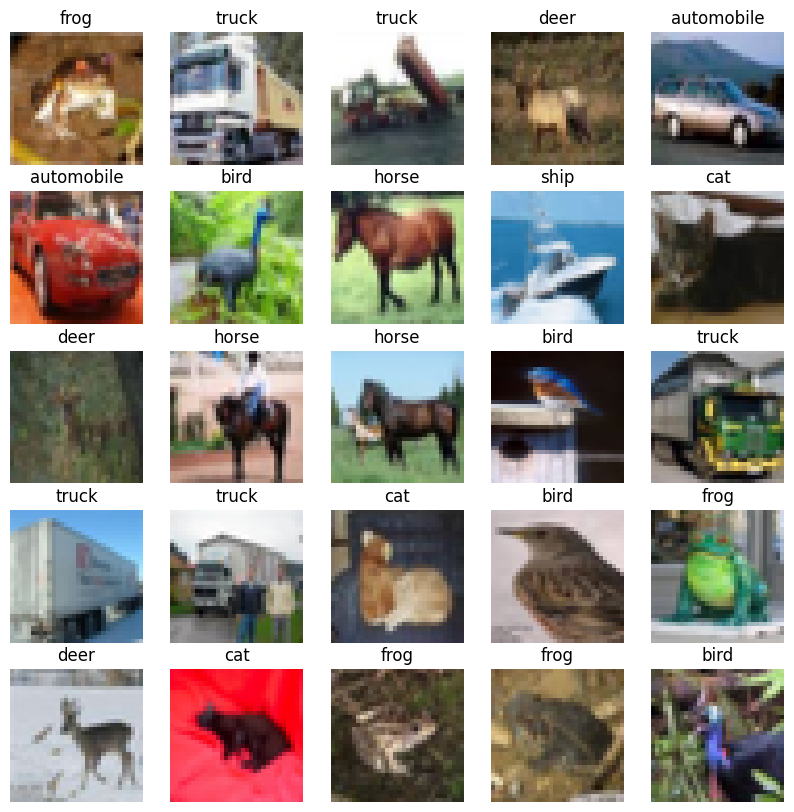

In [6]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

Размерность картинок: 3 канала 32х32 пикселя

In [7]:
image.shape

torch.Size([3, 32, 32])

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(train_loader), len(val_loader)

(1563, 10000)

### Задание 1. Обучить AE (3 балла)

Постройте свой AE, можете использовать любые блоки которые вам кажутся необходимыми.

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=500>

Напишите классы Encoder и Decoder

хинт: вам пригодятся nn.AvgPool2d/nn.MaxPool2d/Conv2d в энкодере и nn.Upsample/nn.ConvTranspose2d в декодере

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (B, 32, 16, 16)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # (B, 64, 8, 8)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # (B, 128, 4, 4)
        )
        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION
        return self.enc(x)
        ### END SOLUTION

In [10]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
assert encoder(noise).view(-1).shape[0] < 1*3*32*32

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.dec = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION
        return self.dec(x)
        ### END SOLUTION

In [12]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
assert decoder(emb).shape == (1, 3, 32, 32)

Посчитаем скор классификации картинок по эмбеддингам необученного энкодора, и в конце сравним с обученным. Для ускорения расчета, мы используем только часть трейна.

In [13]:
def classification_score(encoder, _train_dataset, val_dataset, device):
    encoder.eval()
    torch.manual_seed(0)
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:5000])
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    clf = GradientBoostingClassifier(n_estimators=50, max_depth=5, verbose=1, random_state=0)
    clf.fit(X_train, y_train)
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    return clf.score(X_val, y_val)

In [14]:
classification_score(Encoder(), train_dataset, val_dataset, 'cpu')

100%|██████████| 5000/5000 [00:04<00:00, 1151.14it/s]


      Iter       Train Loss   Remaining Time 
         1           2.0619           40.25m
         2           1.8899           39.35m
         3           1.7467           38.17m
         4           1.6342           37.22m
         5           1.5321           36.33m
         6           1.4431           35.56m
         7           1.3638           34.75m
         8           1.2935           33.95m
         9           1.2282           33.09m
        10           1.1715           32.20m
        20           0.7808           23.94m
        30           0.5756           15.94m
        40           0.4525            8.00m
        50           0.3706            0.00s


100%|██████████| 10000/10000 [00:09<00:00, 1104.75it/s]


0.4345

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
encoder.to(device)
decoder.to(device);

In [17]:
params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)

Напишите функцию train, которая обучает энкодер и декодер на всем трейн сете, возвращает среднюю MSE ошибку

In [18]:
def train(loader, optim, encoder, decoder, device):
    encoder.train()
    decoder.train()
    losses = []
    mse = nn.MSELoss()
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        image = image.to(device)
        optim.zero_grad()
        emb = encoder(image)
        rec = decoder(emb)
        loss = mse(rec, image)
        loss.backward()
        optim.step()
        losses.append(loss.item())
        ### END SOLUTION
    return sum(losses) / len(losses)

In [19]:
loss = train(train_loader, optim, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

0.03549015519858093

Напишите функцию eval, которая возвращает среднюю MSE ошибку по всему валидационному сету

хинт: не забывайте отключать расчет градиентов

In [20]:
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    losses = []
    mse = nn.MSELoss()
    with torch.no_grad():
        for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
            image = image.to(device)
            emb = encoder(image)
            rec = decoder(emb)
            loss = mse(rec, image)
            losses.append(loss.item())
        ### END SOLUTION
    return sum(losses) / len(losses)


In [21]:
loss = eval(val_loader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

0.02322468444481492

Функция full_train возвращает обученный энкодер и декодер. Чтобы пройти ограничения по времени, обучите модель, а затем добавьте загрузку предобученных весов в самое начало функции. Можете использовать шаблон для загрузки весов из Google Drive.

In [22]:
import os

def full_train(device, train_loader, val_loader, checkpoint_dir='./'):
    ### BEGIN SOLUTION
    enc_path = os.path.join(checkpoint_dir, 'encoder.pth')
    dec_path = os.path.join(checkpoint_dir, 'decoder.pth')

    encoder = Encoder().to(device)
    decoder = Decoder().to(device)

    if os.path.exists(enc_path) and os.path.exists(dec_path):
        print("Loading pretrained weights from disk...")
        encoder.load_state_dict(torch.load(enc_path, map_location=device))
        decoder.load_state_dict(torch.load(dec_path, map_location=device))
        return encoder, decoder
    ### END SOLUTION

    params = list(encoder.parameters()) + list(decoder.parameters())
    optim = torch.optim.AdamW(params)
    train_loss = []
    val_loss = []
    n_epochs = 30
    for e in trange(n_epochs):
        e_train_loss = train(train_loader, optim, encoder, decoder, device)
        train_loss.append(e_train_loss)
        e_val_loss = eval(val_loader, encoder, decoder, device)
        val_loss.append(e_val_loss)
        print(f'Epoch: {e+1}/{n_epochs}')
        print(f'Train MSE loss: {e_train_loss:.4f}')
        print(f'Validation MSE loss: {e_val_loss:.4f}')

        # сохраняем чекпоинт каждые 5 эпох
        if (e + 1) % 5 == 0:
            torch.save(encoder.state_dict(), enc_path)
            torch.save(decoder.state_dict(), dec_path)

    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend()
    plt.title('MSE Loss')
    plt.show()

    # последний сохранённый вариант
    torch.save(encoder.state_dict(), enc_path)
    torch.save(decoder.state_dict(), dec_path)
    return encoder, decoder


  3%|▎         | 1/30 [02:02<59:18, 122.71s/it]

Epoch: 1/30
Train MSE loss: 0.0352
Validation MSE loss: 0.0232


  7%|▋         | 2/30 [04:18<1:00:47, 130.27s/it]

Epoch: 2/30
Train MSE loss: 0.0214
Validation MSE loss: 0.0196


 10%|█         | 3/30 [06:28<58:36, 130.23s/it]  

Epoch: 3/30
Train MSE loss: 0.0187
Validation MSE loss: 0.0179


 13%|█▎        | 4/30 [08:39<56:31, 130.45s/it]

Epoch: 4/30
Train MSE loss: 0.0170
Validation MSE loss: 0.0162


 17%|█▋        | 5/30 [11:11<57:41, 138.45s/it]

Epoch: 5/30
Train MSE loss: 0.0158
Validation MSE loss: 0.0171


 20%|██        | 6/30 [13:19<53:57, 134.90s/it]

Epoch: 6/30
Train MSE loss: 0.0151
Validation MSE loss: 0.0147


 23%|██▎       | 7/30 [15:29<51:03, 133.19s/it]

Epoch: 7/30
Train MSE loss: 0.0145
Validation MSE loss: 0.0146


 27%|██▋       | 8/30 [17:44<49:05, 133.87s/it]

Epoch: 8/30
Train MSE loss: 0.0140
Validation MSE loss: 0.0145


 30%|███       | 9/30 [19:56<46:33, 133.03s/it]

Epoch: 9/30
Train MSE loss: 0.0136
Validation MSE loss: 0.0133


 33%|███▎      | 10/30 [22:32<46:47, 140.37s/it]

Epoch: 10/30
Train MSE loss: 0.0133
Validation MSE loss: 0.0131


 37%|███▋      | 11/30 [25:23<47:20, 149.52s/it]

Epoch: 11/30
Train MSE loss: 0.0130
Validation MSE loss: 0.0138


 40%|████      | 12/30 [27:45<44:13, 147.43s/it]

Epoch: 12/30
Train MSE loss: 0.0128
Validation MSE loss: 0.0130


 43%|████▎     | 13/30 [29:52<40:00, 141.23s/it]

Epoch: 13/30
Train MSE loss: 0.0125
Validation MSE loss: 0.0131


 47%|████▋     | 14/30 [32:02<36:42, 137.67s/it]

Epoch: 14/30
Train MSE loss: 0.0123
Validation MSE loss: 0.0121


 50%|█████     | 15/30 [34:11<33:47, 135.18s/it]

Epoch: 15/30
Train MSE loss: 0.0122
Validation MSE loss: 0.0124


 53%|█████▎    | 16/30 [36:29<31:45, 136.10s/it]

Epoch: 16/30
Train MSE loss: 0.0120
Validation MSE loss: 0.0123


 57%|█████▋    | 17/30 [38:40<29:09, 134.54s/it]

Epoch: 17/30
Train MSE loss: 0.0119
Validation MSE loss: 0.0130


 60%|██████    | 18/30 [40:53<26:46, 133.86s/it]

Epoch: 18/30
Train MSE loss: 0.0118
Validation MSE loss: 0.0119


 63%|██████▎   | 19/30 [43:07<24:33, 133.97s/it]

Epoch: 19/30
Train MSE loss: 0.0117
Validation MSE loss: 0.0116


 67%|██████▋   | 20/30 [45:21<22:19, 133.92s/it]

Epoch: 20/30
Train MSE loss: 0.0116
Validation MSE loss: 0.0120


 70%|███████   | 21/30 [48:11<21:42, 144.77s/it]

Epoch: 21/30
Train MSE loss: 0.0115
Validation MSE loss: 0.0119


 73%|███████▎  | 22/30 [50:45<19:41, 147.63s/it]

Epoch: 22/30
Train MSE loss: 0.0114
Validation MSE loss: 0.0112


 77%|███████▋  | 23/30 [53:35<18:01, 154.48s/it]

Epoch: 23/30
Train MSE loss: 0.0113
Validation MSE loss: 0.0115


 80%|████████  | 24/30 [56:11<15:29, 154.96s/it]

Epoch: 24/30
Train MSE loss: 0.0113
Validation MSE loss: 0.0114


 83%|████████▎ | 25/30 [58:50<12:59, 155.96s/it]

Epoch: 25/30
Train MSE loss: 0.0112
Validation MSE loss: 0.0119


 87%|████████▋ | 26/30 [1:03:14<12:33, 188.38s/it]

Epoch: 26/30
Train MSE loss: 0.0111
Validation MSE loss: 0.0111


 90%|█████████ | 27/30 [1:07:49<10:43, 214.52s/it]

Epoch: 27/30
Train MSE loss: 0.0111
Validation MSE loss: 0.0113


 93%|█████████▎| 28/30 [1:09:52<06:13, 186.92s/it]

Epoch: 28/30
Train MSE loss: 0.0110
Validation MSE loss: 0.0111


 97%|█████████▋| 29/30 [1:12:01<02:49, 169.68s/it]

Epoch: 29/30
Train MSE loss: 0.0110
Validation MSE loss: 0.0111


100%|██████████| 30/30 [1:14:11<00:00, 148.40s/it]


Epoch: 30/30
Train MSE loss: 0.0109
Validation MSE loss: 0.0113


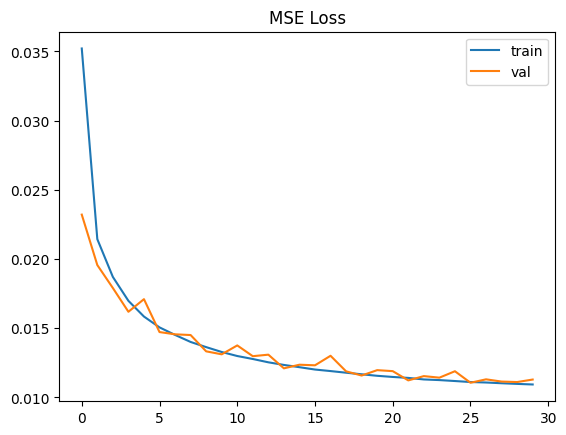

In [23]:
encoder, decoder = full_train(device, train_loader, val_loader)

In [24]:
score = classification_score(encoder, train_dataset, val_dataset, device)
assert score > 0.39
score

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:05<00:00, 833.81it/s]


      Iter       Train Loss   Remaining Time 
         1           2.0412           47.99m
         2           1.8488           46.90m
         3           1.6968           46.11m
         4           1.5685           45.27m
         5           1.4571           44.28m
         6           1.3631           43.35m
         7           1.2790           42.36m
         8           1.2019           41.37m
         9           1.1356           40.41m
        10           1.0736           39.41m
        20           0.6710           29.53m
        30           0.4668           19.73m
        40           0.3419            9.88m
        50           0.2611            0.00s


100%|██████████| 10000/10000 [00:09<00:00, 1058.45it/s]


0.4988

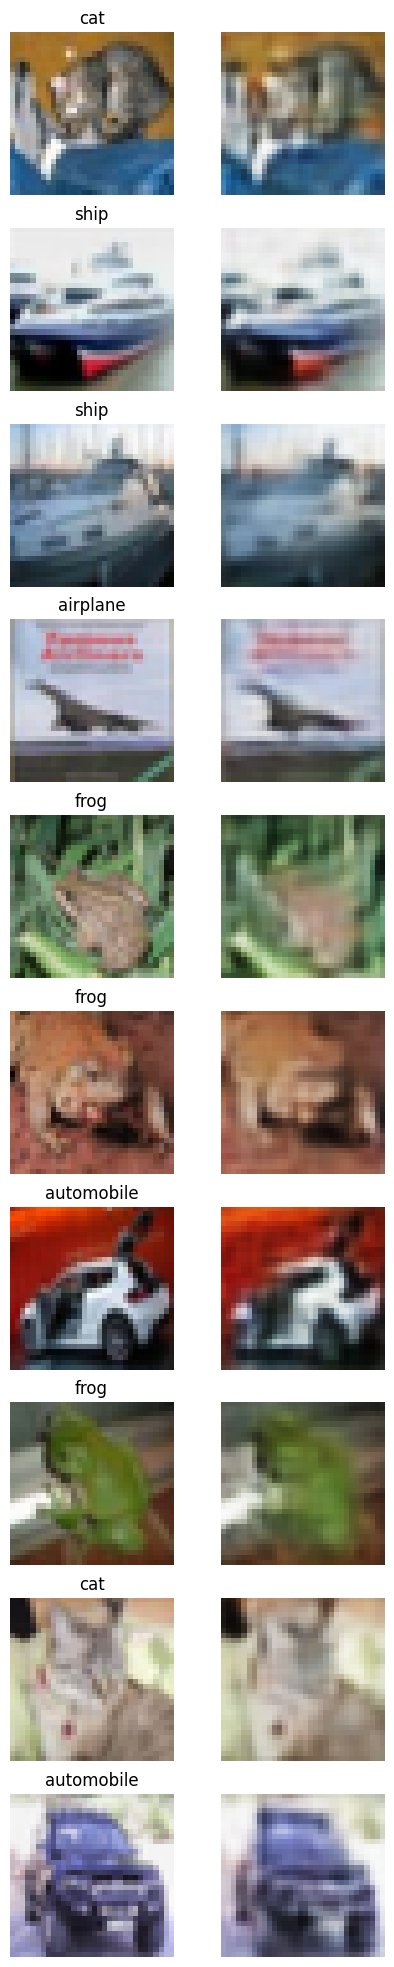

In [26]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2+1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2+2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    if index == 9: break

### Задание 2. FID дистанция между классами CIFAR10 (3 балла)

В этой части хочется чтобы вы, используя bottleneck репрезентации от AE обученного в прошлой части посчитали FID дистанцию между различными классами CIFAR10 на **валидационной** выборке

За копию кода из сети будем снимать баллы

Напишите функцию get_representations, которая возвращает defaultdict, где ключ — это номер класса, значение — это список эмбеддингов, полученных из энкодера.

In [27]:
def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    ### BEGIN SOLUTION
    encoder.eval()
    projection = nn.Linear(128, 256).to(device)  # создаём проекцию в 256-мерное пространство
    with torch.no_grad():
        for image, label in tqdm(dataloader, leave=False):
            image = image.to(device)
            emb = encoder(image)
            emb_flat = emb.mean(dim=(2, 3))
            emb_proj = projection(emb_flat)
            for e, l in zip(emb_proj, label):
                representations[int(l)].append(e.cpu())
    return representations
    ### END SOLUTION

In [28]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10
assert len(representations[0]) == 1000
assert type(representations[0][0]) == torch.Tensor
assert representations[0][0].shape == (256, )

Напишите функцию расчета FID
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+T_{r}\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [52]:
import numpy as np
from scipy import linalg

def calculate_fid(repr1, repr2):
    ### BEGIN SOLUTION
    mu1, mu2 = np.mean(repr1, axis=0), np.mean(repr2, axis=0)
    sigma1, sigma2 = np.cov(repr1, rowvar=False), np.cov(repr2, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return float(np.abs(fid))
    ### END SOLUTION

In [31]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\chizh\AppData\Local\Temp\ipykernel_16024\2691553488.py:10: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)
100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


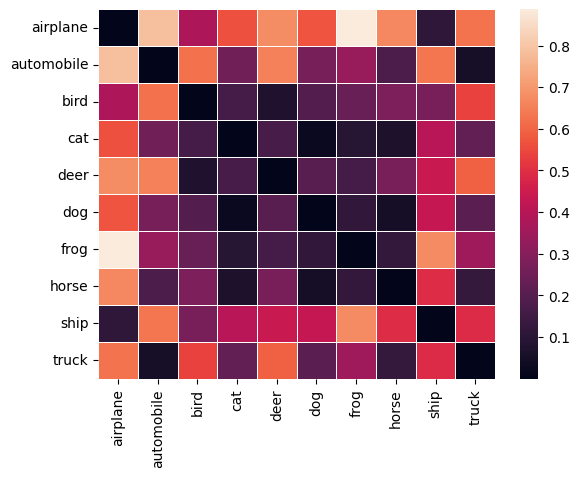

In [32]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.show()

## Задание 3 (3 балла)

Выберите ваш любимый датасет с кошками и собаками и посчитайте FID между двумя классами на новых данных, используя репрезентацию с уже обученного AE

хинт: если любимого датасета с кошками и собаками нет, можно вырезать эти классы из имажнета

хинт: если вам оооочень не нравятся кошки и собаки, то можете выбрать другие два противоположных класса

In [40]:
# YOUR CODE HERE

# Преобразования: уменьшаем размер и нормализуем под [-1, 1]
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

dataset = datasets.STL10(
    root="./stl", 
    split='train', 
    download=True,
    transform=transform
)

100%|██████████| 2.64G/2.64G [04:51<00:00, 9.04MB/s] 


In [54]:
cat_idx = dataset.classes.index("cat")
dog_idx = dataset.classes.index("dog")

cat_images = [(img, label) for img, label in dataset if label == cat_idx]
dog_images = [(img, label) for img, label in dataset if label == dog_idx]

print(f"Кошек: {len(cat_images)}, собак: {len(dog_images)}")

cat_loader = DataLoader(cat_images, batch_size=64, shuffle=False)
dog_loader = DataLoader(dog_images, batch_size=64, shuffle=False)

rep_cats = get_representations(cat_loader, encoder.to(device), device)
rep_dogs = get_representations(dog_loader, encoder.to(device), device)

fid_cat_dog = calculate_fid(
    torch.stack(rep_cats[cat_idx], dim=0).cpu().numpy(),
    torch.stack(rep_dogs[dog_idx], dim=0).cpu().numpy()
)

round(fid_cat_dog, 2)

Кошек: 500, собак: 500


C:\Users\chizh\AppData\Local\Temp\ipykernel_16024\2691553488.py:10: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)


25.14

## Задание 4 (1 балл)

Вы отлично поработали и, скорее всего, в процессе выполнения этих задач у вас появились идеи о том, как еще можно решать подобные проблемы. 

Здесь вы можете описать способы которые вам хотелось бы попробовать если бы у вас было больше времени, или показать статьи которые вы читали, которые решают такие задачи.

Дополнительно, необходимо приложить сюда какой-нибудь смешной мем про генеративные модели за последние два года. Если мем будет не смешным, то баллы придется снять.

**Ответ:**  
Я бы хотел попробовать *гибрид VAE + Diffusion*. Диффузионные модели хорошо справляются с генерацией деталей, а автоэнкодер даёт компактное латентное пространство *(взято из статьи ["Denoising Diffusion Probabilistic Models", 2020](https://arxiv.org/pdf/2006.11239))*